In [1]:
%load_ext autoreload
%autoreload 2

import scipy.io.wavfile as wav
import pyaudio
import wave
import sys
import pyaudio
import scipy
from scipy import signal

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
import matplotlib.mlab as mlab
from numpy import random
#from scipy.fftpack import fft, ifft

from playsound import *
from savetimeseries import *
from combinesignalnoise import *
from combinesignalsignal import *
from plottimeseries import *
from plotsignalnoisetimeseries import *
from plotsignalsignaltimeseries import *
from plotsignalsignalnoisetimeseries import *
from plothistogram import *
from plotpowerspectrum import *

%matplotlib inline

# Optimal non-stationary analysis for BBH background

In [2]:
# useful routine for finding array element nearest to desired value
def find_nearest(array, value):
    idx = np.searchsorted(array, value, side="left")
    if np.abs(value - array[idx-1]) < np.abs(value - array[idx]):
        return idx-1, array[idx-1]
    else:
        return idx, array[idx]

0.0 -235.635404396 -0.24998055534 -2.22224691384e-05


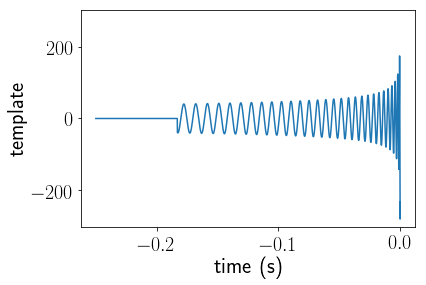

In [3]:
# extract template waveform for BBH chirp
signalfile = 'chirpBBH.txt'
ts = np.loadtxt(signalfile)
t = ts[:,0]
s = ts[:,1]

# chirp duration (corresponds to 100 Hz cutoff for 10 solar mass BHs)
chirp_dur = 0.18306011125

# template is portion of chirp around coalescence time
t0 = 2.
t1 = t0-0.25
t2 = t0

# find indices for t1, t2
n1 = np.where(t>=t1)[0]
n2 = np.where(t>=t2)[0]

template = s[n1[0]:n2[0]]
t_template = t[n1[0]:n2[0]]-t0

print template[0], template[-1], t_template[0], t_template[-1]

# display template
filename = 'chirpBBH_template_short.png'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.plot(t_template, template)

# set symmetric ylimits if both positive and negative
axes = plt.gca()
y1, y2 = axes.get_ylim()
if y1<0. and y2>0.:
    ymin = -max(np.abs(y1),np.abs(y2))
    ymax =  max(np.abs(y1),np.abs(y2))
    axes.set_ylim([ymin, ymax])
    
plt.xlabel('time (s)', size=22)
plt.ylabel('template', size=22)
plt.savefig(filename, bbox_inches='tight', dpi=400)

In [4]:
# extract data for popcorn BBH chirps in white noise in two detectors
A = 0.003
datafile_det1 = 'chirpBNS50BBH10_in_noise_det1_0.003.txt'
datafile_det2 = 'chirpBNS50BBH10_in_noise_det2_0.003.txt'

# extract data from detector 1
ts = np.loadtxt(datafile_det1)
t = ts[:,0]
d1 = ts[:,1]

# extract data from detector 2
ts = np.loadtxt(datafile_det2)
t = ts[:,0]
d2 = ts[:,1]

# some useful quantities
Tobs = t[-1]
deltaT = t[1] - t[0]
N = len(t)
print Tobs, deltaT, N

# injected BNS signal
signalfile1 = 'chirpBNS50_10s.txt'
ts = np.loadtxt(signalfile1)
t = ts[:,0]
s1 = A*ts[:,1]

# injected BBH signal
signalfile2 = 'chirpBBH10_10s.txt'
ts = np.loadtxt(signalfile2)
t = ts[:,0]
s2 = A*ts[:,1]

10.0 4.44446419762e-05 225000


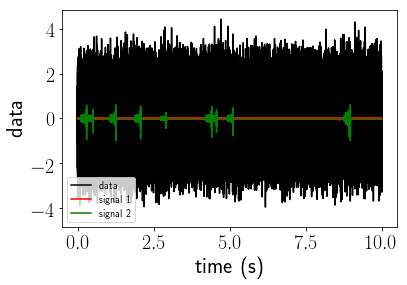

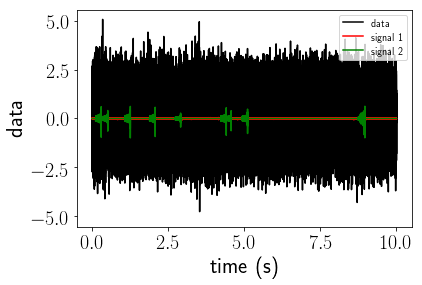

In [5]:
# plot data
fileprefix1 = 'chirpBNS50BBH10_in_noise_det1_0.003_data'
fileprefix2 = 'chirpBNS50BBH10_in_noise_det2_0.003_data'
plotsignalsignalnoisetimeseries(t, s1, s2, d1, t[0], t[-1], fileprefix1)
plotsignalsignalnoisetimeseries(t, s1, s2, d2, t[0], t[-1], fileprefix2)

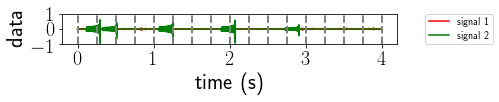

In [6]:
# plot data
fileprefix1 = 'chirpBNS50BBH10_in_noise_det1_0.003_data_zoom'

t1 = 0.
t2 = 4.
n1 = np.where(t>=t1)[0]
n2 = np.where(t>=t2)[0]
    
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.plot(t[n1[0]:n2[0]], s1[n1[0]:n2[0]], color='r')
plt.plot(t[n1[0]:n2[0]], s2[n1[0]:n2[0]], color='g')
            
plt.xlabel('time (s)', size=22)
plt.ylabel('data', size=22)
plt.legend(['signal 1', 'signal 2'], loc='right', bbox_to_anchor=(1.3, 0.5))

# plot segment division limes
for II in range(0,17):
    plt.plot((0.25*II, 0.25*II), (-1., 1.), color='grey', linewidth=2, linestyle='dashed')

plt.ylim([-1.,1.])
plt.axes().set_aspect(1./5.)
plt.savefig('signal_segments.pdf', bbox_inches='tight', dpi=400)

In [7]:
# split data into segments of duration 0.25 sec
Tseg = 0.25 # segment duration (sec)
Nseg = int(Tobs/Tseg) # number of segments
Nsamples = int(N/Nseg) # number of samples per seg

print Tseg, Nseg, Nsamples, N

# initialize
d1I = np.zeros((Nseg, Nsamples))
d2I = np.zeros((Nseg, Nsamples))
tI = np.zeros((Nseg, Nsamples))
for ii in range(0, Nseg):
    tI[ii,:] = t[ii*Nsamples:(ii+1)*Nsamples]
    d1I[ii,:] = d1[ii*Nsamples:(ii+1)*Nsamples]
    d2I[ii,:] = d2[ii*Nsamples:(ii+1)*Nsamples]
    
print tI[0,0], tI[0,-1], tI[1,0], tI[1,-1]

0.25 40 5625 225000
0.0 0.249956666474 0.250001111116 0.49995777759


In [8]:
# priors for A, t0, xi

# A uniform between A_min, A_max
num_A = 10
A_min = 0.5
A_max = 1.5
A = np.linspace(A_min, A_max, num_A)
dA = A[1]-A[0]
prior_A = 1./(num_A*dA)

# t0 uniform between 0 and 2 Tseg
#num_t0 = 45 # -> xi=0.2
#num_t0 = 50 # -> xi=0.1
#num_t0 = 100 # -> xi=0.15
num_t0 = 200 # -> xi=0.25
t0 = np.linspace(0., Tseg+chirp_dur, num_t0)
dt0 = t0[1]-t0[0]
prior_t0 = 1./(num_t0*dt0)

# prob parameter xi uniform between 0 and 1
#num_xi = 50 # faster, but rougher curves
num_xi = 100
xi = np.linspace(0., 1., num_xi)
dxi = xi[1]-xi[0]
prior_xi = 1./(num_xi*dxi)

In [9]:
def gauss_lnlike(d1, d2, sigma2):

    '''
    gaussian log likelihood (assumes white noise)
    '''
    
    N = len(d1)
    y1 = -0.5*N*np.log(2.*np.pi*sigma2) - (0.5/sigma2)*np.sum(d1**2)
    y2 = -0.5*N*np.log(2.*np.pi*sigma2) - (0.5/sigma2)*np.sum(d2**2)
    y  = y1 + y2
    
    # include an overall constant to make y1, y2 closer to zero
    const = 16000.
   
    y = y + const
    
    return y

In [10]:
def mixture_like(t, d1, d2, sigma2, A, t0, template, xi):
    
    '''
    mixture likelihood function
    '''
    r1, r2 = residual(t, d1, d2, A, t0, template)
    y = xi*np.exp(gauss_lnlike(r1, r2, sigma2)) + (1.0-xi)*np.exp(gauss_lnlike(d1, d2, sigma2))
    
    #print gauss_lnlike(r1, r2, sigma2), gauss_lnlike(d1, d2, sigma2), y
    
    return y

In [11]:
def shifted_template(t_template, template, t0):

    '''
    shift template so coalescence at t0 rather than at the end of the segment
    '''
    
    # shift times so that template starts at 0
    t = t_template - t_template[0]
    N = len(t)
    
    if 0.<=t0<=t[-1]:
        # find index where t>t0 (chirp should be zero for these t's)
        ndx = np.where(t>t0)[0]
        #y = np.concatenate((template[(N-1)-ndx[0]:-1],np.zeros(N-ndx[0])), axis=0)
        y = np.concatenate((template[N-ndx[0]:],np.zeros(N-ndx[0])), axis=0)
    
    elif t[-1]<t0<=2.*t[-1]:
        t_end = 2.*t[-1] - t0
        # find index where t>=tend (chirp should be non-zero for these t's)
        ndx = np.where(t>=t_end)[0]
        #y = np.concatenate((np.zeros(N-ndx[0]),template[0:ndx[0]]), axis=0)
        y = np.concatenate((np.zeros(N-ndx[0]-1),template[0:ndx[0]+1]), axis=0)

    return y

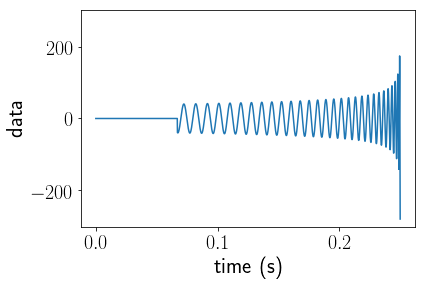

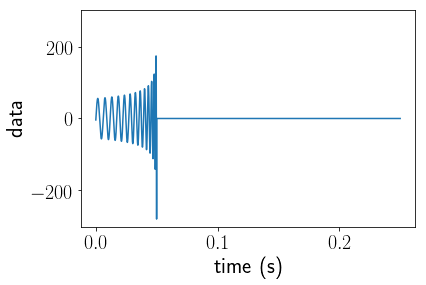

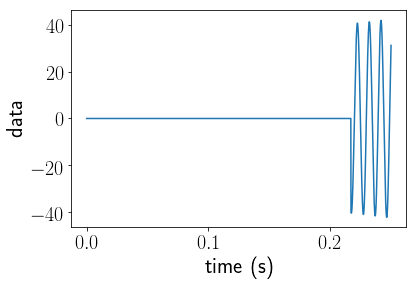

In [12]:
# plot shifted template
h = shifted_template(t_template, template, Tseg)
t_h = t_template + Tseg
fileprefix = 'temp_template_0.25'
plottimeseries(t_h, h, t_h[0], t_h[-1], fileprefix)

h = shifted_template(t_template, template, 0.05)
t_h = t_template + Tseg
fileprefix = 'temp_template_0.05'
plottimeseries(t_h, h, t_h[0], t_h[-1], fileprefix)

#h = shifted_template(t_template, template, Tseg+chirp_dur-deltaT)
h = shifted_template(t_template, template, 0.40)
t_h = t_template + Tseg
fileprefix = 'temp_template_0.4'
plottimeseries(t_h, h, t_h[0], t_h[-1], fileprefix)

#print template[0], template[0:0], template[0:1], template[-1], template[N-1:]

In [13]:
def residual(t, d1, d2, A, t0, template):
    
    '''
    calculate residuals by subtracting off signal model from data
    '''
    
    # extract relevant quantities from the data
    N = len(t)
    t1 = t[0]
    t2 = t[-1]

    # calculate time (relative to start time of segment for shifted template)
    delta_t = t0-t1
    h = shifted_template(t, template, delta_t)
    
    # calculate residual
    r1 = d1 - A*h 
    r2 = d2 - A*h

    return r1, r2

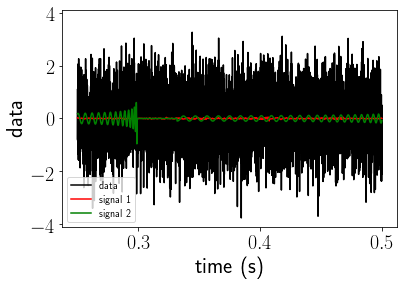

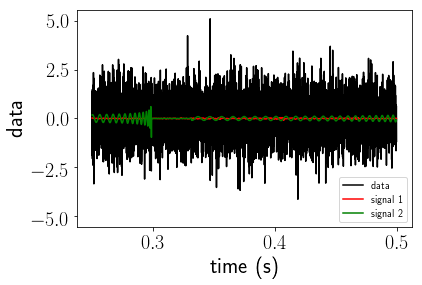

In [14]:
# plot a segment of data
seg = 1 # remember that seg=0 is really the 1st segment
fileprefix1 = 'segment1_det1'
fileprefix2 = 'segment1_det2'
plotsignalsignalnoisetimeseries(tI[seg, :], 
                                s1[seg*Nsamples:(seg+1)*Nsamples], 
                                s2[seg*Nsamples:(seg+1)*Nsamples],
                                d1I[seg,:], tI[seg,0], tI[seg,-1], fileprefix1)
plotsignalsignalnoisetimeseries(tI[seg, :], 
                                s1[seg*Nsamples:(seg+1)*Nsamples], 
                                s2[seg*Nsamples:(seg+1)*Nsamples],
                                d2I[seg,:], tI[seg,0], tI[seg,-1], fileprefix2)

In [15]:
# calculate ln likelihood for each data segment
sigma2 = 1
A_norm = 0.003

# initialize variables
signal_lnlikeI = np.zeros((Nseg, num_A, num_t0))
noise_lnlikeI  = np.zeros(Nseg)
signal_like_margI = np.zeros(Nseg)
temp2 = np.zeros(num_A)

like_margI = np.zeros((Nseg, num_xi)) # non-stationary likelihood
like_marg  = np.zeros(num_xi)         # combined over segments

for II in range(0, Nseg):
    print 'finished', II, 'out of', Nseg, 'segments'
    
    # noise likelihood
    noise_lnlikeI[II] = gauss_lnlike(d1I[II,:], d2I[II,:], sigma2)
        
    # signal likelihood (depends on chirp parameters)
    for KK in range(0, num_A):
        
        for LL in range(0, num_t0): 
            
            r1, r2 = residual(tI[II,:], d1I[II], d2I[II,:], 
                              A_norm*A[KK], tI[II,0]+t0[LL], template)
            signal_lnlikeI[II, KK, LL] = gauss_lnlike(r1, r2, sigma2)
       
        # marginalize signal likelihood over t0
        temp2[KK] = np.sum(np.exp(signal_lnlikeI[II, KK, :]))*dt0*prior_t0
            
    # marginalize signal likelihood over A
    signal_like_margI[II] = np.sum(temp2)*dA*prior_A  

    # include non-stationarity parameter
    for JJ in range(0, num_xi):
        like_margI[II, JJ] = xi[JJ]*signal_like_margI[II] + (1.-xi[JJ])*np.exp(noise_lnlikeI[II])
        

finished 0 out of 40 segments
finished 1 out of 40 segments
finished 2 out of 40 segments
finished 3 out of 40 segments
finished 4 out of 40 segments
finished 5 out of 40 segments
finished 6 out of 40 segments
finished 7 out of 40 segments
finished 8 out of 40 segments
finished 9 out of 40 segments
finished 10 out of 40 segments
finished 11 out of 40 segments
finished 12 out of 40 segments
finished 13 out of 40 segments
finished 14 out of 40 segments
finished 15 out of 40 segments
finished 16 out of 40 segments
finished 17 out of 40 segments
finished 18 out of 40 segments
finished 19 out of 40 segments
finished 20 out of 40 segments
finished 21 out of 40 segments
finished 22 out of 40 segments
finished 23 out of 40 segments
finished 24 out of 40 segments
finished 25 out of 40 segments
finished 26 out of 40 segments
finished 27 out of 40 segments
finished 28 out of 40 segments
finished 29 out of 40 segments
finished 30 out of 40 segments
finished 31 out of 40 segments
finished 32 out of

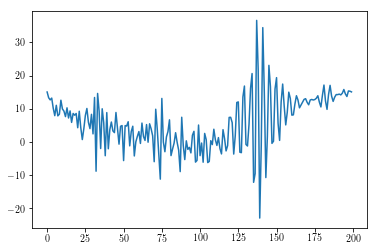

In [16]:
# diagnostic
plt.plot(signal_lnlikeI[0,0,:])

In [17]:
# combine segments
for JJ in range(0, num_xi):                      
    like_marg[JJ] = np.exp(np.sum(np.log(like_margI[:,JJ])))
    
# marginalize over xi to get evidence for signal model
like_BBH = np.sum(like_marg)*dxi*prior_xi

# evidence for noise model (combine segments)
like_noise = np.exp(np.sum(noise_lnlikeI))

# bayes factor and SNR
twolnBF = 2.0*np.log(like_BBH/like_noise)
SNR = np.sqrt(twolnBF)

print '2 ln(BF) = ', twolnBF
print 'SNR = ', SNR

2 ln(BF) =  233.289246122
SNR =  15.2738091556


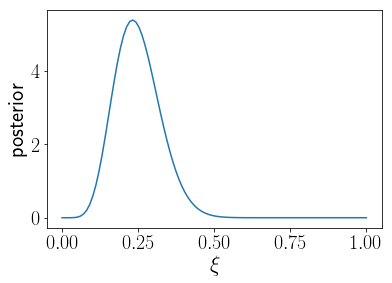

In [18]:
# plot posterior for xi (combining all segments, averaged over chirp params)

# NOTE: posterior distribution is proportional to the likelihood for flat priors
# normalize probability distributions
like_marg = like_marg/np.sum(like_marg*dxi)

filename = 'posterior_xi.pdf'
plt.figure()
plt.rc('text', usetex=True)
plt.tick_params(labelsize=20)
plt.plot(xi, like_marg)    
plt.xlabel(r'$\xi$', size=22)
plt.ylabel('posterior', size=22)
plt.savefig(filename, bbox_inches='tight', dpi=400)

/Users/joeromano/src/virtualenvs/dev/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


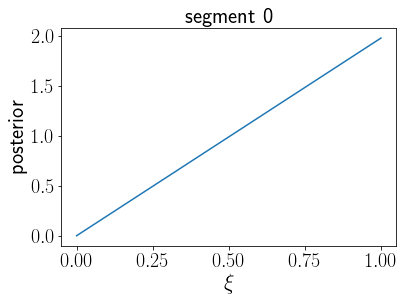

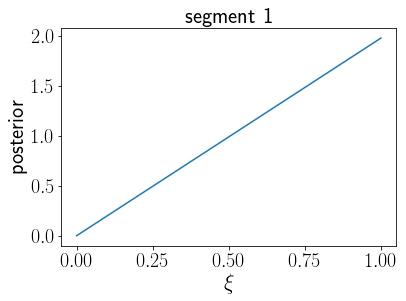

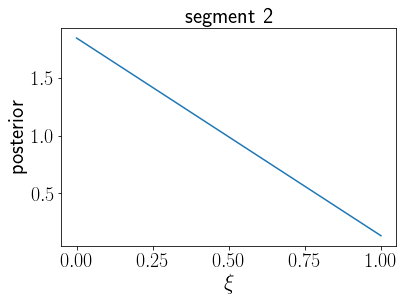

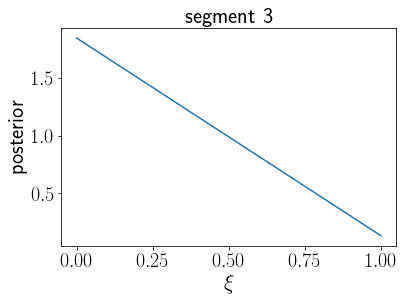

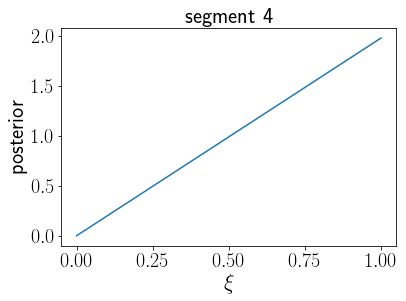

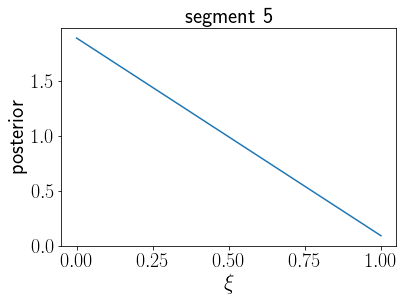

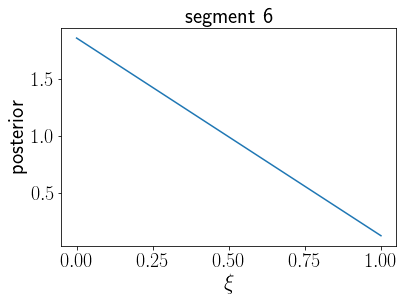

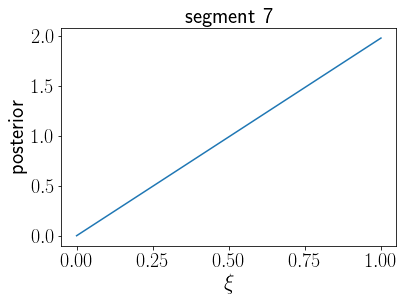

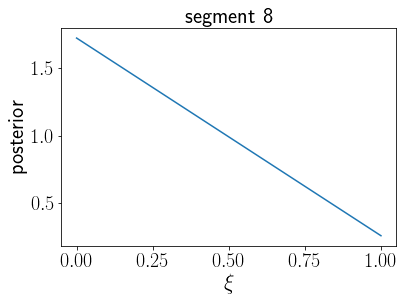

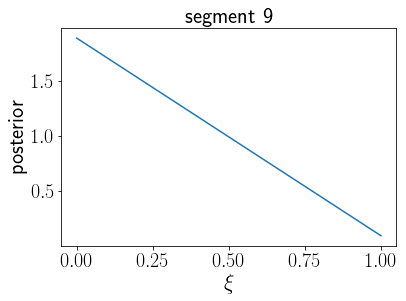

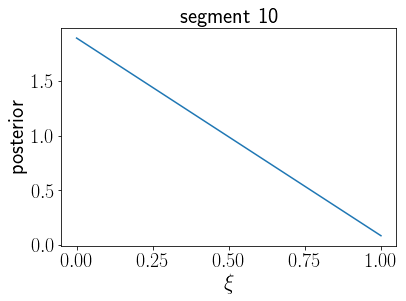

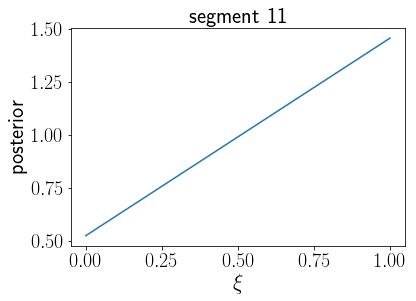

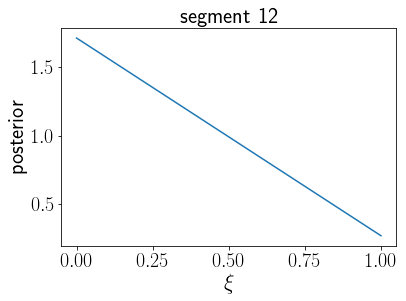

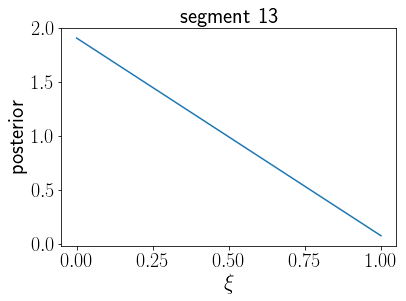

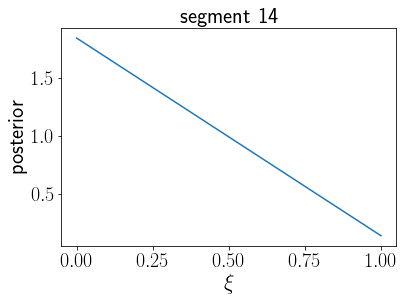

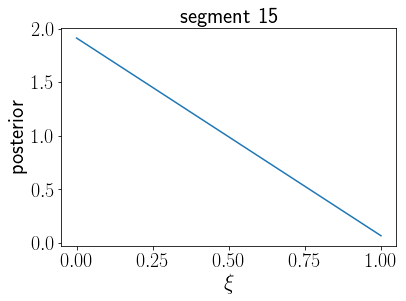

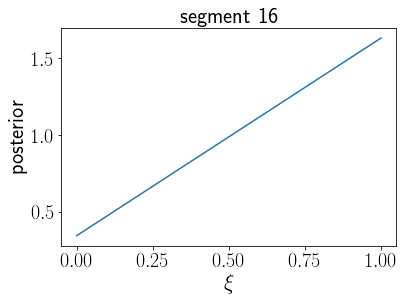

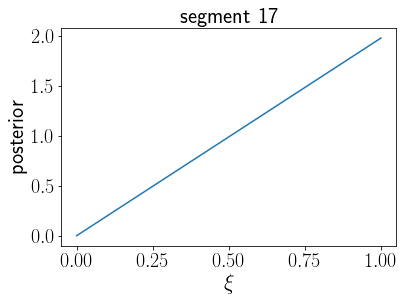

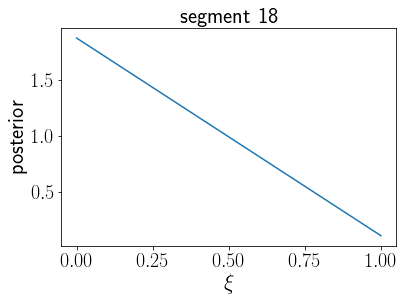

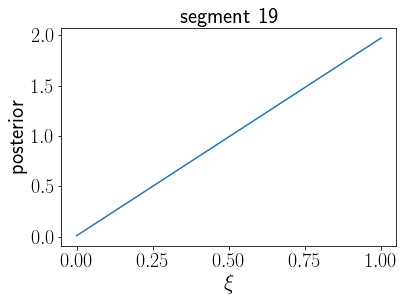

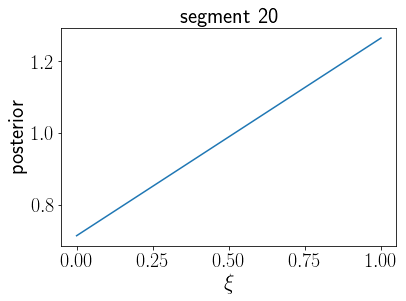

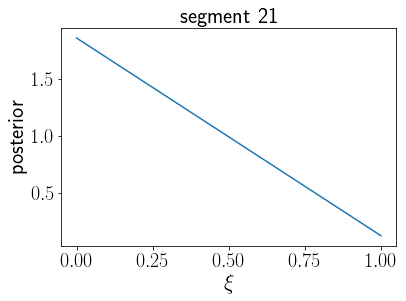

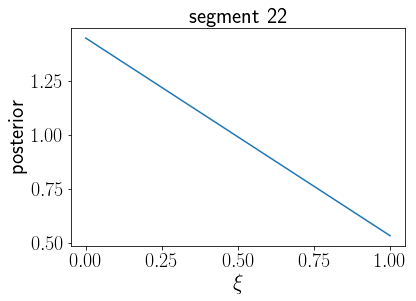

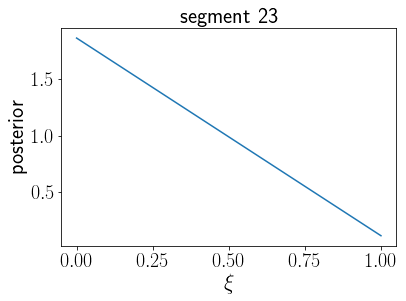

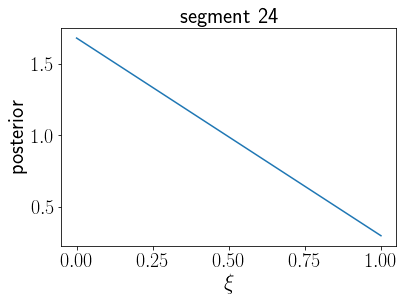

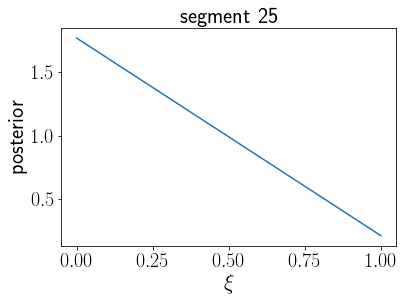

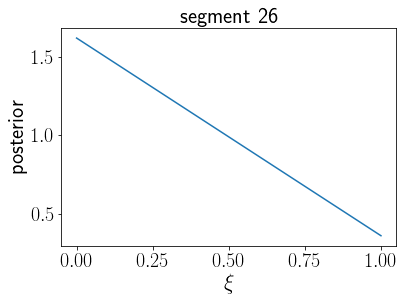

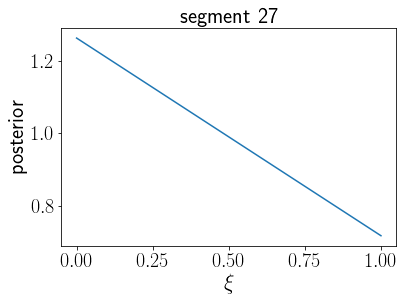

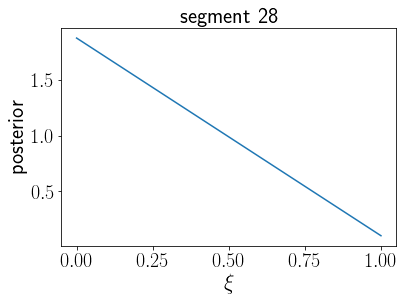

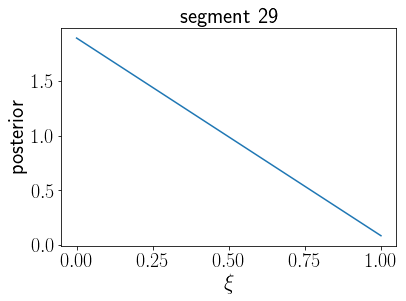

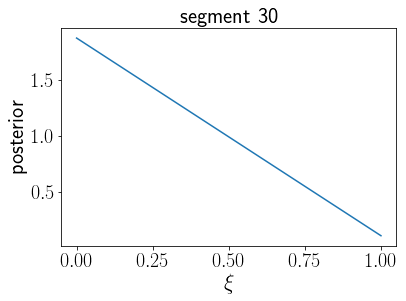

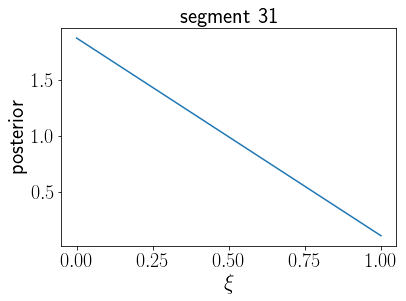

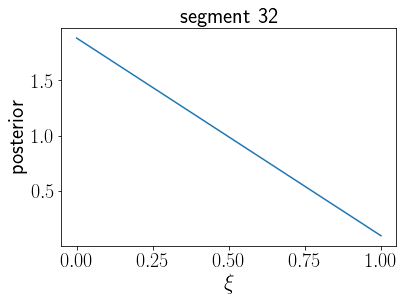

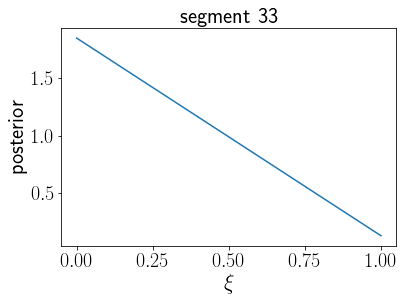

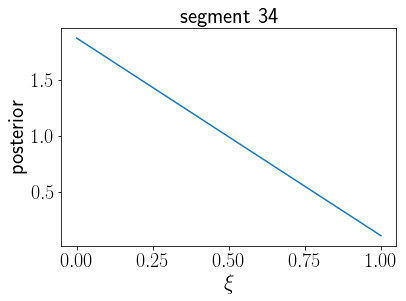

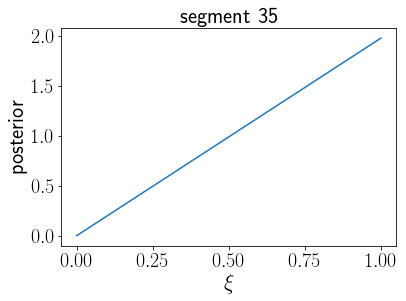

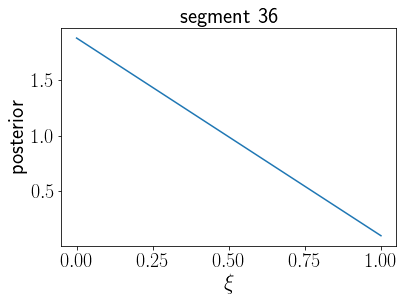

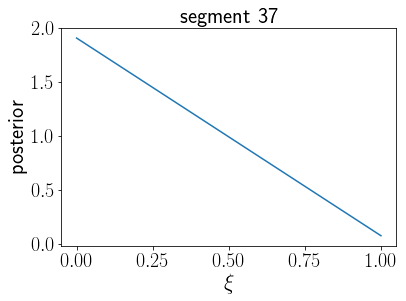

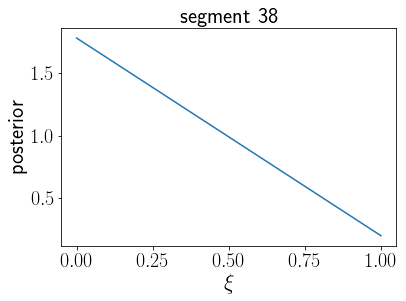

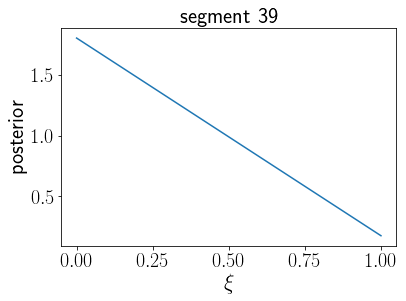

In [19]:
# plot posteriors for xi (for each segment, averaged over chirp parameters)

for II in range(0, Nseg):
    
    like_margI[II,:] = like_margI[II,:]/np.sum(like_margI[II,:]*dxi)

    filename = 'posterior_xi_seg_' + str(II) + '.pdf'
    titlestr = 'segment ' + str(II)
    plt.figure()
    plt.rc('text', usetex=True)
    plt.tick_params(labelsize=20)
    plt.plot(xi, like_margI[II,:])    
    plt.xlabel(r'$\xi$', size=22)
    plt.ylabel('posterior', size=22)
    plt.title(titlestr, size=22)
    plt.savefig(filename, bbox_inches='tight', dpi=400)

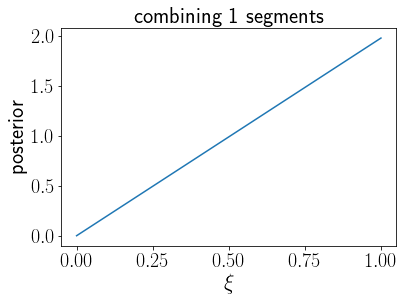

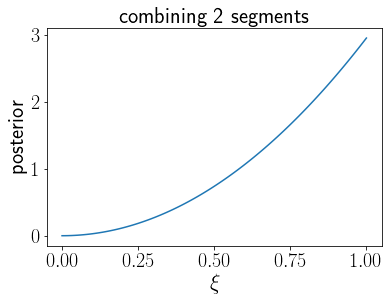

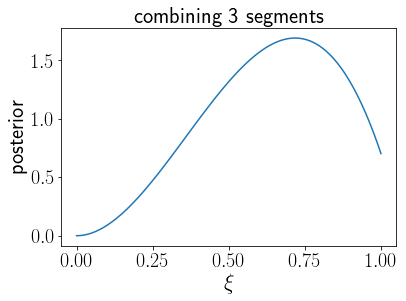

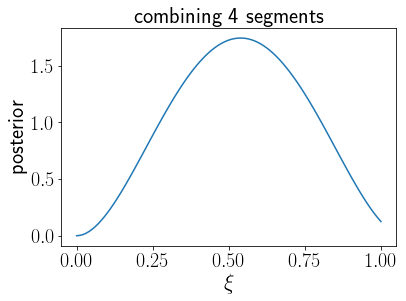

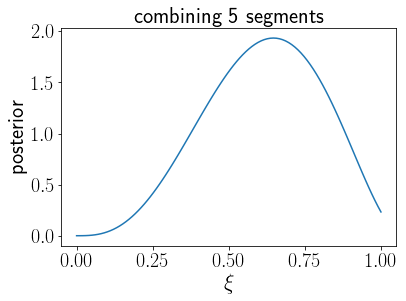

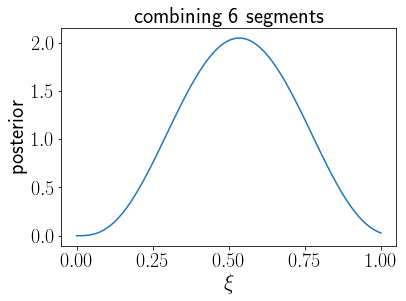

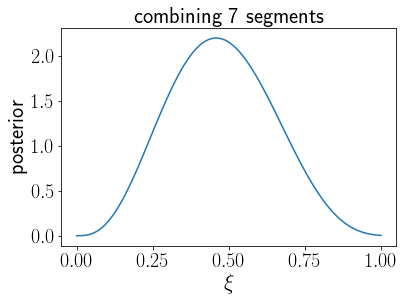

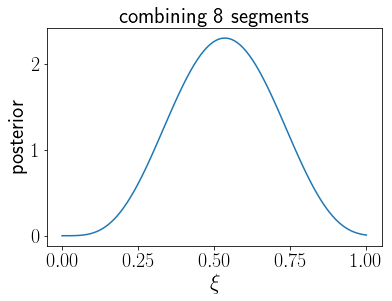

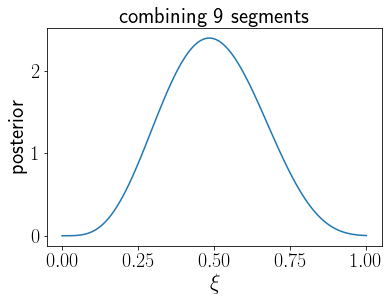

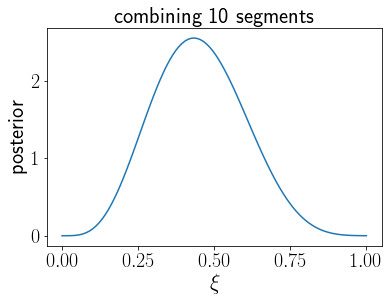

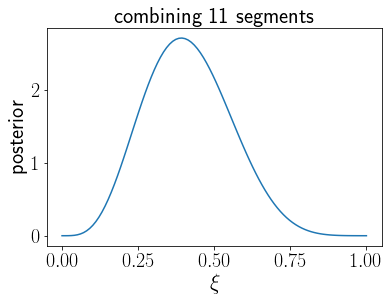

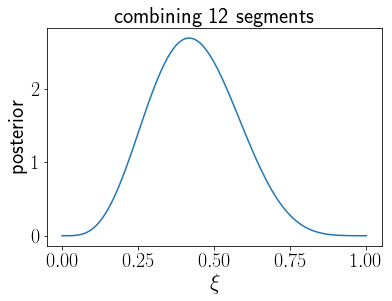

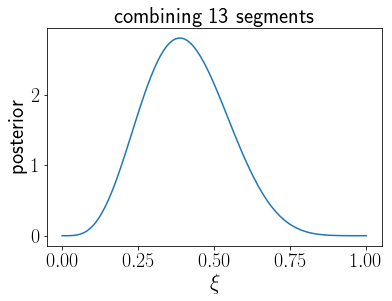

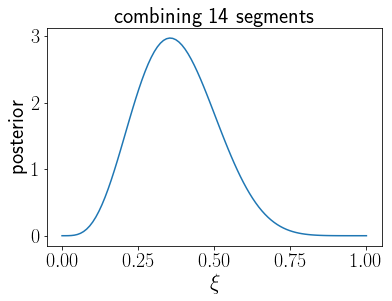

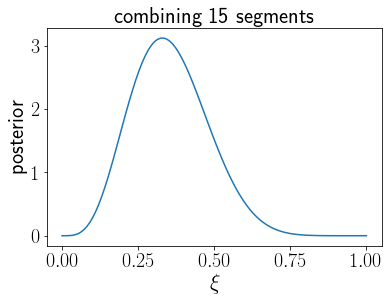

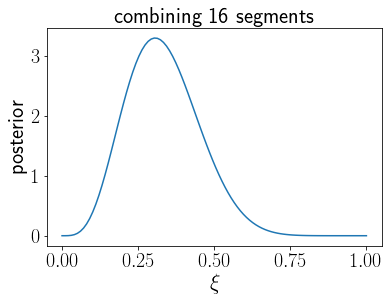

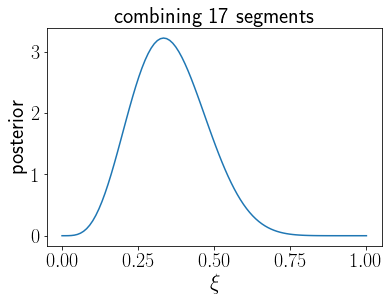

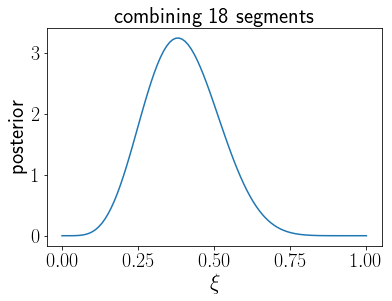

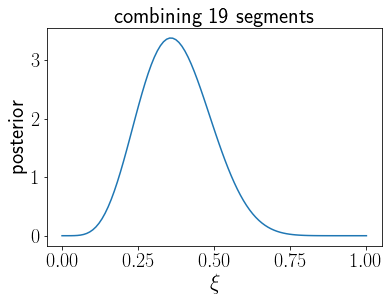

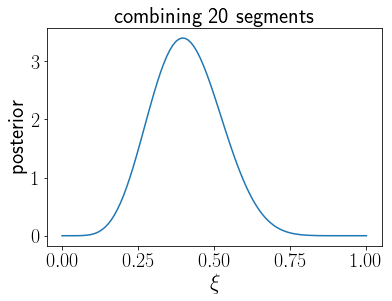

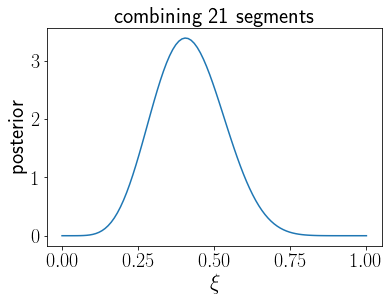

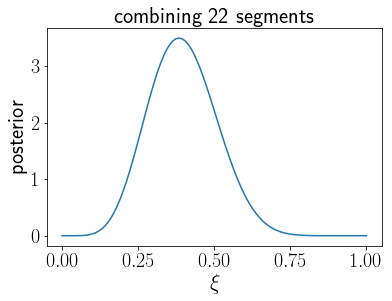

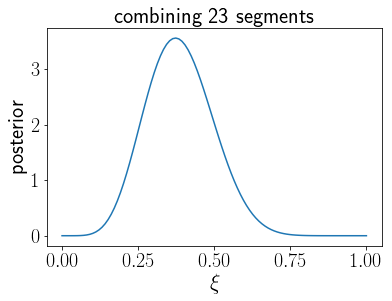

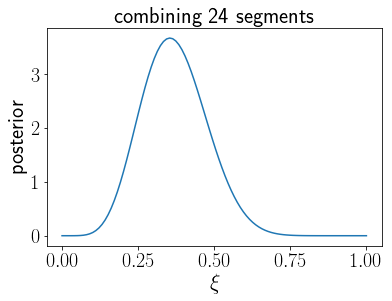

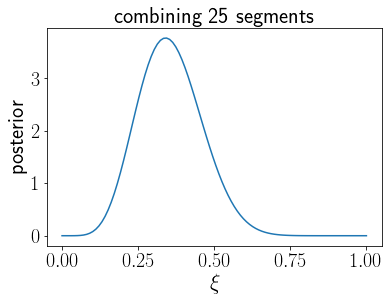

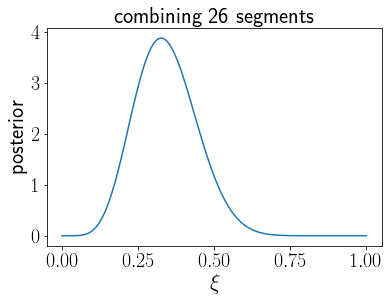

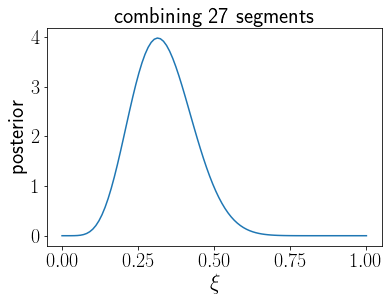

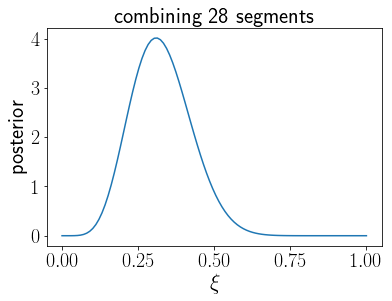

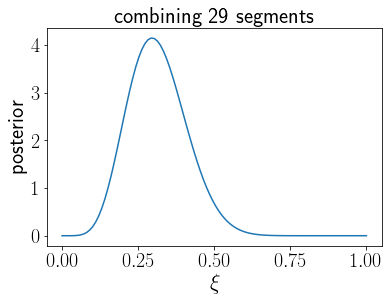

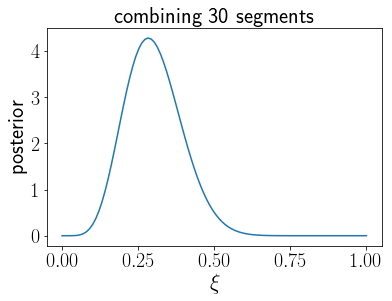

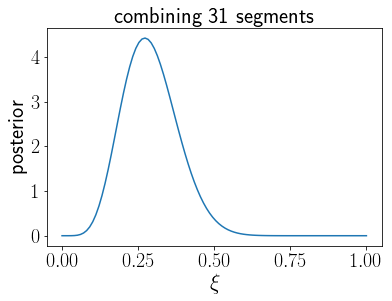

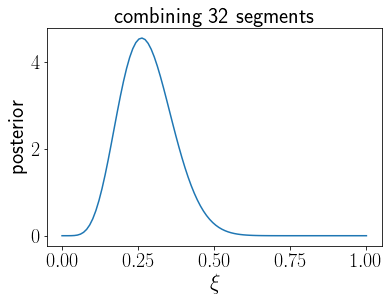

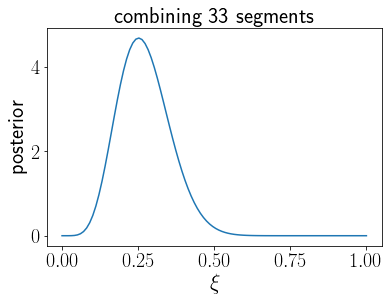

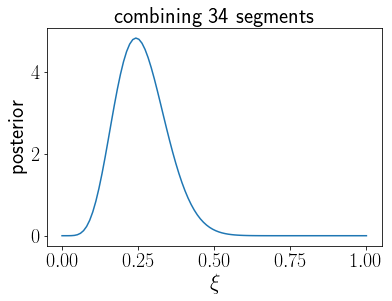

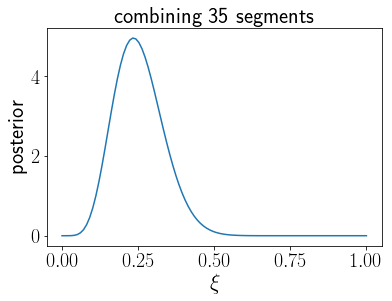

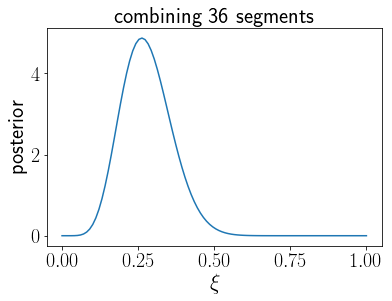

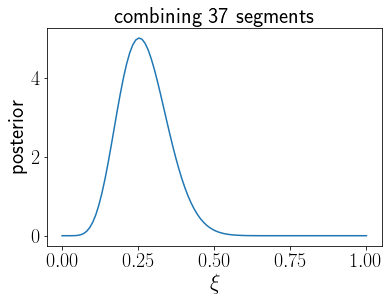

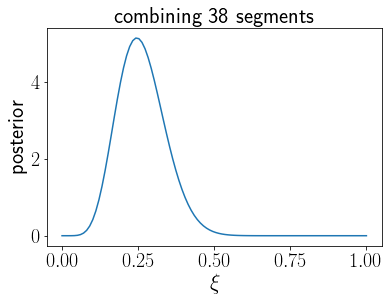

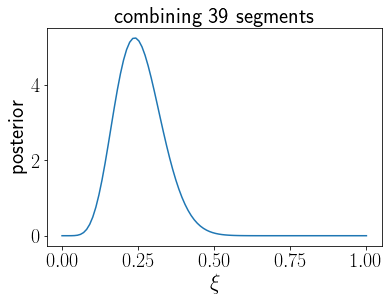

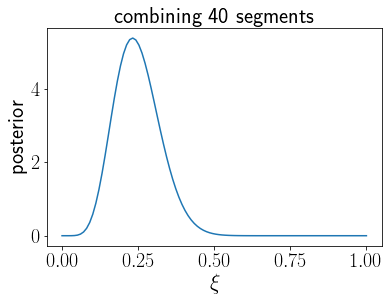

In [20]:
# plot posterior for xi as running product over segments (averaged over chirp parameters)

running_prod = np.ones(num_xi)

for II in range(0, Nseg):
    
    running_prod = running_prod * like_margI[II,:]
    running_prod = running_prod/np.sum(running_prod*dxi)
    
    filename = 'posterior_xi_cum_' + str(II) + '.pdf'
    titlestr = 'combining ' + str(II+1) + ' segments'
    plt.figure()
    plt.rc('text', usetex=True)
    plt.tick_params(labelsize=20)
    plt.plot(xi, running_prod)    
    plt.xlabel(r'$\xi$', size=22)
    plt.ylabel('posterior', size=22)
    plt.title(titlestr, size=22)
    plt.savefig(filename, bbox_inches='tight', dpi=400)
    
    